In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.datasets import *
from fastai.vision import *
from fastai import *

import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import json



In [2]:
ROOT_PATH=Path('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/')
DATA_PATH=Path(ROOT_PATH/'data')
VOC_DEVKIT_PATH = Path(DATA_PATH/'VOCdevkit')
MODEL_PATH=Path(ROOT_PATH/'model')
TRAIN_PATH=Path(ROOT_PATH/'train')               
VOC_DEVKIT_PATH.ls()





[PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/pascal_val2007.json'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/.ipynb_checkpoints'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/pascal_train2007.json')]

In [3]:
train_json_path = Path(VOC_DEVKIT_PATH/'pascal_train2007.json')
with open(train_json_path, 'r') as f:
    train_json = json.loads(f.read())

IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']



In [4]:
train_json[IMAGES][:5], train_json[ANNOTATIONS][:3],train_json[CATEGORIES][:5]

([{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
  {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
  {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
  {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
  {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}],
 [{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
   'area': 34104,
   'iscrowd': 0,
   'image_id': 12,
   'bbox': [155, 96, 196, 174],
   'category_id': 7,
   'id': 1,
   'ignore': 0},
  {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
   'area': 13110,
   'iscrowd': 0,
   'image_id': 17,
   'bbox': [184, 61, 95, 138],
   'category_id': 15,
   'id': 2,
   'ignore': 0},
  {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]],
   'area': 81326,
   'iscrowd': 0,
   'image_id': 17,
   'bbox': [89, 77, 314, 259],
   'category_id': 13,
   'id': 3,
   'ignore': 0}],
 [{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},


### Create dict from id to category (dict[id] -> category)

In [5]:
categories = dict([(c['id'], c['name']) for c in train_json[CATEGORIES]])

### Create map of id to image file (dict[id] -> filename)

In [6]:
images = dict([(i['id'], i['file_name']) for i in train_json['images']])

### List of image ids

In [7]:
image_ids = [i['id'] for i in train_json['images']]

In [8]:
JPEGS_PATH = Path(VOC_DEVKIT_PATH/'VOC2007'/'JPEGImages')
IMAGES_PATH = JPEGS_PATH
JPEGS_PATH.ls()[:5]

[PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages/001618.jpg'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages/005169.jpg'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages/002201.jpg'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages/006238.jpg'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages/005960.jpg')]

In [9]:
train_json[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

### Create a dict with image_id to bounding box and category dict[image_id] -> (bbox, category)

1. The goal here is to create a dictionary that maps an `image_id` to the `bbox` and `category`
2. This requires a few additional helper methods described below 

<br>

### Helper methods
<br>




#### Changing BBOX representation format
1. The information in the `annotations` dictionary has an attribute called `bbox` which is represented in a notation usually used in ML, which is width by height whereas most libraries and math representation is width by height 

<br>

#### TLDR;
 - Math world - rows by columns (height by width)
 - Computer Vision  - columns by rows (width by height)



In [10]:
def create_train_annotations(train_json:dict):
    """
    1. creates an annotations dictionary 
    2. converts the format in which height and width is stored in the 
    annotations dictionary of the train_json dict.
    3. Also converts the height and width information to top left x, y cordinate and bottom right x, y coordinate
    Hence the subtraction information
    """
    annotations = collections.defaultdict(lambda:[])
    for o in train_json[ANNOTATIONS]:
        bbox = o['bbox']
        bb = np.array([bbox[1], bbox[0], bbox[3]+bbox[1], bbox[2]+bbox[0]])
        annotations[o['image_id']].append((bb, o['category_id']))
    return annotations

def get_category(category_id): 
    cat = categories.get(category_id, None)
    if not cat: 
        cat = val_categories.get(category_id, None)
    return cat

def get_image_filename(image_id): 
    filename = images.get(image_id, None)
    if not filename:
        filename = val_images.get(image_id, None)
    return filename
        
def _get_annotations(image_id): 
    annot =  annotations.get(image_id, None)
    if not annot:
        annot = val_annotations.get(image_id, None)
    return annot


def convert_bb_to_height_and_width(bbox):
    """
    Does the opposite. 
    1. Converts bbox x, y coordinates for top left and bottom right to height and width information
    """
    bb = bbox
    return np.array([bb[1], bb[0], bb[3]-bb[1], bb[2]-bb[0]])

def _open_image(filename):
    """
    1. opens an image with just the filename using the standard `open_image` method
    """
    return open_image(JPEGS_PATH/filename)

def _display_with_bbox(img_filename, bbox:list=None):
    """
    1. Creates bounding boxes using FastAIs ImageBBox api
    """
    if isinstance(img_filename, str):
        img = _open_image(img_filename)
    else:
        img = img_filename
        
    if not isinstance(bbox, ImageBBox):        
        bb, category = bbox    
        category_name = category if isinstance(category, list) else get_category(category)
        img_bbox = ImageBBox.create(*img.size, bb, labels=[0], classes=list(category_name))        
    else:
        img_bbox = bbox
    img.show(y=img_bbox, figsize=(5, 5))
    
def _get_largest_img_bbox(img_annotation):
    if not img_annotation: raise Exception
    sorted_bbox = sorted(img_annotation, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return sorted_bbox[0]


def display_batch(ds_type:DatasetType=DatasetType.Train, num=15):
    x, y = data.one_batch(ds_type=ds_type)
    
    if ds_type == DatasetType.Train:
        xs = [ data.train_ds.x.reconstruct(grab_idx(x, i)) for i in range(num)]
        ys = [ data.train_ds.y.reconstruct(grab_idx(y, idx), x=x) for idx, x in enumerate(xs)]
    else:
        xs = [ data.valid_ds.x.reconstruct(grab_idx(x, i)) for i in range(num)]
        ys = [ data.valid_ds.y.reconstruct(grab_idx(y, idx), x=x) for idx, x in enumerate(xs)]
    axs = subplots(3, 3, imgsize=(5, 5), figsize=(20, 20))
    for im, bb, ax in zip(xs, ys, axs.flatten()):     
        im.show(ax=ax, y=bb, hide_axis=False)
        ax.grid(b=True, color='gray', visible=True, zorder=0.8)
        ax.set_axisbelow(True)    
    
    

In [11]:
annotations = create_train_annotations(train_json)
get_category(7), get_image_filename(12)

('car', '000012.jpg')

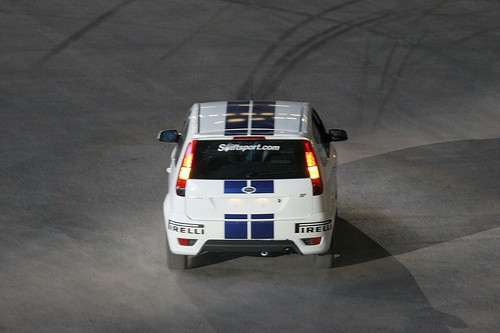

In [12]:
first_img = list(images.values())[0]
_open_image(first_img)

### Creating images with bounding boxes using ImageBBox

```python
img = open_image('imgs/car_bbox.jpg')
bbox = ImageBBox.create(*img.size, [[96, 155, 270, 351]], labels=[0], classes=['car'])
img.show(y=bbox)
```

### Use fastai helper to fetch json data `get_annotations`

In [13]:
imgs, lbl_bbox = get_annotations(VOC_DEVKIT_PATH/'pascal_train2007.json')
imgs_valid, lbl_bbox_valid = get_annotations(VOC_DEVKIT_PATH/'pascal_val2007.json')

imgs2bbox = dict(zip(imgs, lbl_bbox))
imgs2bbox_valid = dict(zip(imgs_valid, lbl_bbox_valid))

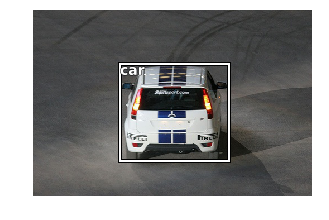

In [14]:
imgs[0], lbl_bbox[0]

_display_with_bbox(imgs[0], lbl_bbox[0])

### Create a label function to pull the bbox and classes from the `img2bbox and img2bbox_valid` dictionaries

In [15]:
def get_y_func(o):
    bbox_classes = imgs2bbox.get(o.name, None)
    if not bbox_classes: bbox_classes = imgs2bbox_valid.get(o.name, None)
    bbox, classes = bbox_classes
    return [bbox, classes]

In [16]:
print(get_y_func(Path(JPEGS_PATH/f'{imgs[0]}')))
print(get_y_func(Path(JPEGS_PATH/f'{imgs_valid[0]}')))

[[[96, 155, 270, 351]], ['car']]
[[[210, 262, 339, 324], [263, 164, 372, 253], [243, 4, 374, 67], [193, 240, 299, 295], [185, 276, 220, 312]], ['chair', 'chair', 'chair', 'chair', 'chair']]


In [17]:
from fastai.vision.data import bb_pad_collate

In [18]:
bs=16

In [19]:
tfms = get_transforms(xtra_tfms=cutout(n_holes=(1,4), length=(2, 70), p=0.5, use_on_y=False), max_rotate=4., 
                      max_zoom=1.1, p_affine=0.5, p_lighting=0.5 )

In [20]:
data = ObjectItemList.from_folder(JPEGS_PATH)
data = data.split_by_rand_pct(valid_pct=0.2)
data = data.label_from_func(get_y_func)
data = data.transform(tfms,
                     tfm_y=True, size=224, resize_method=ResizeMethod.SQUISH)
data = data.databunch(bs=bs, collate_fn=bb_pad_collate)
data = data.normalize(imagenet_stats)

In [21]:
data

ImageDataBunch;

Train: LabelList (4009 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Valid: LabelList (1002 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Test: None

In [22]:
data.classes

['background',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [23]:
#display_batch(DatasetType.Valid)
#data.show_batch(ds_type=DatasetType.Valid)

### MultiClass Object Detection 

1. One approach is to allow the models last layer to return (4 + data.c) where 4 is the bounding box coordinates and c is the class of the predicted grid
2. We could also ensure it returns $16 * (4+data.c)$ to return 16 bounding boxes with 4 coordinate bounding boxes for each along with class 
3. `c = len(cats)`

### Not a linear final layer anymore

1. Instead of an `nn.Linear` final layer we have an `nn.Conv2D` final layer
2. The final layer of Resnet is $7x7x512$ and adding a `Conv2D` with `stride=2` would result in an output of shape `4x4x(4+data.c)`


### YOLO vs SSD (Single Shot Detector)

1. YOLO uses the `nn.Linear` final layer which returns a single vector
2. YOLO v3 and SSD uses a convolutional layer which returns $4x4x(4+data.c)$

### Stride 2 Conv2d is the same as Conv2D with MaxPooling

### How do we end up with an output of shape 16 x (4 + c)

1. Where `c` is the number of classes. 
2. The layer before the output layer is of shape `(256 x 7 x 7 )`

```
[SSDhead] input shape torch.Size([16, 512, 7, 7])
[SSDHead-1] relu-dropout output shape torch.Size([16, 512, 7, 7])
[SSDHead-2] sconv0 output shape torch.Size([16, 256, 7, 7])
[SSDHead-3] sconv0 output shape torch.Size([16, 256, 4, 4])
[SSDHead-4] out output shape (2,)
```

Our SSD which looks like 

```python
    def __init__(self, k, bias, num_of_classes):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512, 256, stride=1) 
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, 256, num_of_classes, bias)
        
    def forward(self, x):
        print(f'[SSDhead] input shape {x.shape}')
        x = self.drop(F.relu(x))
        print(f'[SSDHead-1] relu-dropout output shape {x.shape}')
        x = self.sconv0(x)
        print(f'[SSDHead-2] sconv0 output shape {x.shape}')
        x = self.sconv2(x)
        print(f'[SSDHead-3] sconv2 output shape {x.shape}')
        x = self.out(x)
        print(f'[SSDHead-4] out output shape {np.array(x).shape}')
        return x
    
```

1. Has a convolution which accepts the `512 x 7 x 7` from the last resnet layer. 
2. This is followed by a stride 1 (`self.sconv0 = StdConv(512, 256, stride=1)`) which doesn't change the shape of activations.
3. The next layer `svconv2` is a standard Conv2d with stride 2 which would reduce the shape to `4x4` which gives us the 16 additional activations.
4. So when flattened our output shape looks like 16 x ( 4 + c ) but since our `OutConv` layer separates the results into two lists 

```python
class OutConv(nn.Module):
    def __init__(self, k, nin, num_classes, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(in_channels=nin, out_channels=((num_classes) * k), kernel_size=3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):        
        return [flatten_conv(self.oconv1(x), self.k), 
                flatten_conv(self.oconv2(x), self.k)]
```

We end up with two outputs of shape 
1. 16x(c) - 16 x 16 x 21 
2. 16x(4) - 16 x 16 x 4

With the first 16 denoting the batch size in this example


In [24]:
conv2d.__module__

'fastai.layers'

## Architecture


### Defining our new final layers 

1. A `StdConv` a basic convolutional layer with `Conv2d`, `BatchNorm2d` and `Dropout`

In [25]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, kernel_size=3, stride=2, padding=1, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

### What Flatten is doing internally

1. Assuming we have a 4x4 input 

```python
t =    torch.tensor([[ 5.1227e-01,  7.6558e-02,  1.5598e+00,  9.6250e-01],
          [-8.7642e-01,  9.7873e-01,  2.1760e+00,  1.2043e+00],
          [-1.6135e+00,  4.4954e-01,  3.6084e-01,  1.3405e-01],
          [-4.0809e-01, -2.2286e-01, -8.5558e-01,  8.2284e-01]])

print(t.shape)
>> torch.Size([4, 4])

print(t.view(t.shape[0], t.shape[1], -1))
>> tensor([[[ 0.5123],
         [ 0.0766],
         [ 1.5598],
         [ 0.9625]],

        [[-0.8764],
         [ 0.9787],
         [ 2.1760],
         [ 1.2043]],

        [[-1.6135],
         [ 0.4495],
         [ 0.3608],
         [ 0.1340]],

        [[-0.4081],
         [-0.2229],
         [-0.8556],
         [ 0.8228]]])

t.view(t.shape[0], t.shape[1], -1).transpose(1, 2)
>> tensor([[[ 0.5123,  0.0766,  1.5598,  0.9625]],

        [[-0.8764,  0.9787,  2.1760,  1.2043]],

        [[-1.6135,  0.4495,  0.3608,  0.1340]],

        [[-0.4081, -0.2229, -0.8556,  0.8228]]])

t.view(t.shape[0], t.shape[1], -1).transpose(1, 2).shape
>>torch.Size([4,1,4])
```



In [26]:
def flatten_conv(x, k, debug=False): 
    if debug: print(f'[Flatten] Input shape {x.shape}, k={k}')        
        
    bs, num_features, row, cols = x.shape
    flattened = x.view(bs, num_features//k, -1)
    
    if debug: print(f'[Flatten-2] Flattened shape {flattened.shape}')
        
    return flattened.permute(0,2,1)

### Visualize the outcome of StdConv

1. We have 3 input channels for a color image
2. 64 filters and a kernel size of $3x3$

In [27]:
x, y = data.one_batch()
print(f'Input shape: {x.shape}')
s = StdConv(3, 64, kernel_size=3, stride=1)
x_ = s.forward(x)
print("Output shape {x_.shape}")

Input shape: torch.Size([16, 3, 224, 224])
Output shape {x_.shape}


### OutConv defines the output layer

In [28]:
class OutConv(nn.Module):
    def __init__(self, k, nin, num_classes, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(in_channels=nin, out_channels=((num_classes) * k), kernel_size=3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        #self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x, debug=False):        
        _classes = self.oconv1(x)
        _coords = self.oconv2(x)
        if debug: print(f'[OutConv]: classes: {_classes.shape}, coords: {_coords.shape}')
                  
        classes = flatten_conv(_classes, self.k)
        coords = flatten_conv(_coords, self.k)
        if debug: print(f'[OutConv] Flattened classes: {classes.shape} Flattened coords: {coords.shape}')
            
        return [classes, coords]
        

In [29]:
# [SSDhead] input shape torch.Size([16, 512, 7, 7])
# [SSDHead-1] relu-dropout output shape torch.Size([16, 512, 7, 7])
# [SSDHead-2] sconv0 output shape torch.Size([16, 256, 7, 7])
# [SSDHead-3] sconv2 output shape torch.Size([16, 256, 4, 4])
# [SSDHead-4] sconv3 output shape torch.Size([16, 256, 2, 2])
# [SSDHead-4] sconv4 output shape torch.Size([16, 256, 1, 1])
# [OutConv]: classes: torch.Size([16, 189, 1, 1]), coords: torch.Size([16, 36, 1, 1])

class SSDHead(nn.Module):
    def __init__(self, k, bias, num_of_classes):
        super().__init__()
        self.drop = nn.Dropout(0.5)
        #self.sconv_1 = StdConv(2048, 1024, stride=1) #1024x7x7 (additinal)
        #self.sconv_2 = StdConv(1024, 512, stride=1) #512x7x7  (additinal)
        self.sconv0 = StdConv(512, 256, stride=1) #256x7x7
        self.sconv1 = StdConv(256, 256, stride=1) #256x7x7 (additinal)
        self.sconv2 = StdConv(256, 256) #256x4x4
        self.sconv3 = StdConv(256, 256) #256x2x2
        self.sconv4 = StdConv(256, 256) #256x1x1
        self.out = OutConv(k, 256, num_of_classes, bias)
        
    def forward(self, x, debug=False):
        if debug: print(f'[SSDhead] input shape {x.shape}')
        x = self.drop(F.relu(x))
        if debug: print(f'[SSDHead-1] relu-dropout output shape {x.shape}')
        #x = self.sconv_2(self.sconv_1(x))    
        x = self.sconv0(x)
        if debug: print(f'[SSDHead-2] sconv0 output shape {x.shape}')
        x = self.sconv1(x)
        x = self.sconv2(x)
        c1, bb1 = self.out(x)        
        if debug: 
            print(f'[SSDHead-3] sconv2 output shape {x.shape}')
            
        
        x = self.sconv3(x)
        c2, bb2 = self.out(x)
        if debug: 
            print(f'[SSDHead-4] sconv3 output shape {x.shape}')
            print(f'[SSDHead-4] c2 {c2.shape}  bb1: {bb2.shape}')
        
        x = self.sconv4(x)
        c3, bb3 = self.out(x)
        
        if debug: 
            print(f'[SSDHead-5] sconv4 output shape {x.shape}')        
            
            print(f'[SSDHead-5] c1 {c1.shape}  bb1: {bb1.shape}')
            print(f'[SSDHead-5] c2 {c2.shape}  bb1: {bb2.shape}')
            print(f'[SSDHead-5] c3 {c3.shape}  bb1: {bb3.shape}')
        
        c, bb = torch.cat([c1, c2, c3], dim=1), torch.cat([bb1, bb2, bb3], dim=1)        
        if debug: print(f'[SSDHead-6] concatenated shape c: {c.shape}, b:{bb.shape}')
            
        return [c, bb]
    
    

In [30]:
k = 9
bias = -3.
head_reg4 = SSDHead(k, bias, data.c)


### Anchors in summary

- Details on how each line of the anchors works can be found below

### Anchors with Zoom and scales

1. We don't use these yet as our model is not returning outputs that caters to 3 different zooms. 
2. However, the ideal output would be when the model is able to predict outputs with these zooms. 
3. As we look at the outputs at the bottom, we notice that some of the predictions are incorrect because when the model tries to predict the object in a grid cell it predicts it based on the what it thinks to be present only within that single grid cell without the larger image in context.

In [31]:
def get_scaled_anchors():    
    anc_grids = [4, 2, 1]
    anc_zooms = [0.7, 1., 1.3]
    anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

    anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                        for (i,j) in anc_ratios]
    # *** Number of Anchor Scales
    k = len(anchor_scales)
    # ***************************

    anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
    anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                            for ao,ag in zip(anc_offsets,anc_grids)])
    anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                            for ao,ag in zip(anc_offsets,anc_grids)])
    anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
    anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
                  for i in range(ag*ag) for o,p in anchor_scales])
                     for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
    grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
                  for i in range(ag*ag) for o,p in anchor_scales])
                      for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
    anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()
#     anchor_cnr = cthw2corners(anchors)
    print(f'K is {k}')
    return anchors, grid_sizes

anchors, grid_sizes = get_scaled_anchors()
anchors, grid_sizes

K is 9


(tensor([[-0.7500, -0.7500,  0.3500,  0.3500],
         [-0.7500, -0.7500,  0.3500,  0.1750],
         [-0.7500, -0.7500,  0.1750,  0.3500],
         [-0.7500, -0.7500,  0.5000,  0.5000],
         [-0.7500, -0.7500,  0.5000,  0.2500],
         [-0.7500, -0.7500,  0.2500,  0.5000],
         [-0.7500, -0.7500,  0.6500,  0.6500],
         [-0.7500, -0.7500,  0.6500,  0.3250],
         [-0.7500, -0.7500,  0.3250,  0.6500],
         [-0.7500, -0.2500,  0.3500,  0.3500],
         [-0.7500, -0.2500,  0.3500,  0.1750],
         [-0.7500, -0.2500,  0.1750,  0.3500],
         [-0.7500, -0.2500,  0.5000,  0.5000],
         [-0.7500, -0.2500,  0.5000,  0.2500],
         [-0.7500, -0.2500,  0.2500,  0.5000],
         [-0.7500, -0.2500,  0.6500,  0.6500],
         [-0.7500, -0.2500,  0.6500,  0.3250],
         [-0.7500, -0.2500,  0.3250,  0.6500],
         [-0.7500,  0.2500,  0.3500,  0.3500],
         [-0.7500,  0.2500,  0.3500,  0.1750],
         [-0.7500,  0.2500,  0.1750,  0.3500],
         [-0.

In [32]:
anchors

tensor([[-0.7500, -0.7500,  0.3500,  0.3500],
        [-0.7500, -0.7500,  0.3500,  0.1750],
        [-0.7500, -0.7500,  0.1750,  0.3500],
        [-0.7500, -0.7500,  0.5000,  0.5000],
        [-0.7500, -0.7500,  0.5000,  0.2500],
        [-0.7500, -0.7500,  0.2500,  0.5000],
        [-0.7500, -0.7500,  0.6500,  0.6500],
        [-0.7500, -0.7500,  0.6500,  0.3250],
        [-0.7500, -0.7500,  0.3250,  0.6500],
        [-0.7500, -0.2500,  0.3500,  0.3500],
        [-0.7500, -0.2500,  0.3500,  0.1750],
        [-0.7500, -0.2500,  0.1750,  0.3500],
        [-0.7500, -0.2500,  0.5000,  0.5000],
        [-0.7500, -0.2500,  0.5000,  0.2500],
        [-0.7500, -0.2500,  0.2500,  0.5000],
        [-0.7500, -0.2500,  0.6500,  0.6500],
        [-0.7500, -0.2500,  0.6500,  0.3250],
        [-0.7500, -0.2500,  0.3250,  0.6500],
        [-0.7500,  0.2500,  0.3500,  0.3500],
        [-0.7500,  0.2500,  0.3500,  0.1750],
        [-0.7500,  0.2500,  0.1750,  0.3500],
        [-0.7500,  0.2500,  0.5000

### Loss Function (now includes Focal loss `get_weights`)

1. `pad_target_class` and `pad_target_coords` ensure both target and predictions shape match 
2. We add `get_weights` which uses Focal Loss
3. Focal loss is essentially a scaled version Cross entropy loss.
4. The constants `alpha` and `gamma` are used based on the values suggested in the Focal Loss paper by Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He, Piotr Dollar available here https://arxiv.org/pdf/1708.02002.pdf
5. The term logits can be confusing and is used to refer to probabilities but in ML it's usually something that's going to be mapped through a `Softmax` layer to generate normalised probabilties.

In [105]:
def one_hot_embedding(labels, num_classes, debug=False):
    if debug: 
        print(f'labels: {labels} {labels.shape}')
        print(f'num_classes: {num_classes}')
        print(f'lables.data {labels.data}')
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        """
        The t[:, 1:] and p[:, 1:] ensures the first class `background` is ignored in both target and predicted classes
        """        
        t = one_hot_embedding(targ, self.num_classes)[:, 1:]
        t= t.cuda()
        x = pred[:,1:]       
        w = self.get_weight(x,t,focal_loss=True) # for focal loss
        return F.binary_cross_entropy_with_logits(x, t, w, reduction='sum')/(self.num_classes - 1)
    
    def get_weight(self,x,t, focal_loss=False): 
        if not focal_loss: return None
        x,t = x.cpu(),t.cpu()
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return (w * (1-pt).pow(gamma)).cuda().detach()
    
    
    

In [112]:
def get_nonzero(bbox,classes):
    """
    Accepts a target_coords and classes
    1. bbox: target_coords 
    2. classes: target_classes
    
    It ensures thes shape is [whatever size x 4], ie: groups of 4 coords
    It checks if the difference between x2 - x1 is > 0  and filters all the `nonzero` values indexes
    
    And using those indexes `bb_keep` returns those from the orignal `bbox` and `classes` arrays
    """
    #bbox = bbox.view(-1,4)/224.
    bbox = bbox.view(-1,4)
    retain_idxs = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[retain_idxs],classes[retain_idxs]

# Getting rid of -ve values 
def normalize(bbox, debug=False):
    if debug:
        print(f'[NORMALIZE] bbox: {bbox} bbox.sum: {bbox.sum()} bbox.std: {bbox.std()} bbox.mean: {bbox.mean()}')
    return (bbox+1./2.)


def hw2corners(boxes):
    top = (boxes[:,0] - boxes[:,2]/2).view(-1,1)
    left = (boxes[:,1] - boxes[:,3]/2).view(-1,1)
    bot = (boxes[:,0] + boxes[:,2]/2).view(-1,1)
    right = (boxes[:,1] + boxes[:,3]/2).view(-1,1)
    return torch.cat([top,left,bot,right],dim=1)

def hw2corners_(ctr, hw):
    """
    Given the center and the height and width returns the 4 corners of a bounding box
    """
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)


def intersect(box_a, box_b):
    """
    for a given set of pred_coords and anchor boxes
    1. `max_xy` finds the right most top left coordinates. That is max(x) and max(y)
    2. `min_xy` finds the furthest bottom right,  `bottom left`. That is min(x) and min(y)
    3. `clamp` ensures the values are greater than 0
    4. `inter * inter` computes the areas of the two sets of coordinates and returns the overlapping area.
    """
    top_left = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    bottom_right = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    inter = torch.clamp((bottom_right - top_left), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_area(b): 
    return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b, debug=False):
    """
    Intersection over union
    """
    if debug:
        print(f'[JACCARD] box_a: {box_a}')
        print(f'[JACCARD] box_b: {box_b}')
    inter = intersect(box_a, box_b)
    union = box_area(box_a).unsqueeze(1) + box_area(box_b).unsqueeze(0) - inter
    return inter / union


def actn_to_bb(actn, anchors, grid_sizes, debug=False):
    """
    Given a set of 
    1. actn: activations from a prediction
    2. anchors: Anchors computed beforehand for a default image of size 1x1. (anchors)
    3. grid_sizes: Grid size for each of the bounding box on the default image
    4. The tanh converts the values between -1 and 1
    Anchors return the list of (anchor_centers, anchor_sizes)
    
    """    
    actn_bbs = torch.tanh(actn)
    if debug:
        print(f'actn_bbs: {actn_bbs.shape} anchors: {anchors.shape} grid_size: {grid_sizes.shape}')
        
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners_(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, debug=False):
    """
    `overlaps.max(1)`:
        1. returns the overlap of the activations with the ground truth anchor boxes
        2. Which is returns the largest overlaps (area) and anchor box index       
    
    `overlaps.max(0)`:
        1. returns overlap of activations overlap with respect to each of the
           ground truth boxes
        2. For every anchor box in our anchors the overlap area and the activation that overlapped
     
     The function assigns every anchor box to a ground truth label.
    """
    if debug: print(f'[MAP_TO_GROUND_TRUTH] overlaps: {overlaps}')
    overlap_val, overlap_idx = overlaps.max(1)    
    gt_overlap, gt_idx = overlaps.max(0) 
    
    if debug: 
        print(f'[MAP_TO_GROUND_TRUTH] overlap_val:{overlap_val}, overlap_idx:{overlap_idx}')
        print(f'[MAP_TO_GROUND_TRUTH] gt_overlaps: {gt_overlap}, gt_idx:{gt_idx}')
        
    gt_overlap[overlap_idx] = 1.99
    for ix, overlap_index in enumerate(overlap_idx):
        gt_idx[overlap_index]=ix
        
    if debug:
        print(f'[MAP_TO_GROUND_TRUTH] gt_overlaps: {gt_overlap}')
        print(f'[MAP_TO_GROUND_TRUTH] gt_idx: {gt_idx}')      
            
    return gt_overlap, gt_idx   
    
    

def ssd_1_loss(p_cls, p_coords, t_cls, t_coords, debug=False):
    t_coords, t_cls = get_nonzero(t_coords, t_cls) # this divides by 224 to work on 1x1 image size  
    #t_coords = normalize(t_coords) # we do this to obtain non-negative bounding boxes to train on.
    
    if debug:        
        print(f'[SSD_1_LOSS] t_coords = {t_coords.shape}')
        print(f'[SSD_1_LOSS] t_cls = {t_cls.shape}')
        print(f'[SSD_1_LOSS] p_coords = {p_coords.shape}')    
        print(f'[SSD_1_LOSS] p_cls = {p_cls.shape}')
   
    anchor_centers = anchors[:, :2]
    anchor_hw = anchors[:, 2:]
    anchor_corners = hw2corners_(anchor_centers.cuda(), anchor_hw.cuda())  
    overlaps = jaccard(t_coords, anchor_corners.cuda())
    try:
        gt_overlap, gt_idx = map_to_ground_truth(overlaps)
    except Exception as e:
        return 0., 0.
    
    gt_classes = t_cls[gt_idx]
    positive_overlaps = gt_overlap > 0.4
    positive_overlaps_idx = torch.nonzero(positive_overlaps)[:, 0]

    if debug: print(f'[SSD_1_LOSS] gt_classes: {gt_classes}')

    # if the overlaps are False replace that with 21 for all else retain the actual class label index
    gt_classes[~positive_overlaps] = len(data.classes)
    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_classes.detach()] #Ground truth labels
    
    if debug:
        print(f'[SSD_1_LOSS] gt_classes1: {gt_classes}')
        print(f'[SSD_1_LOSS] gt_label: {gt_label} {len(gt_label)}')
    
    gt_bbox = t_coords[gt_idx]
    actn_centers_hw = actn_to_bb(p_coords, anchors.cuda(), grid_sizes.cuda())  
    loc_loss = (
        actn_centers_hw[positive_overlaps_idx] - gt_bbox[positive_overlaps_idx]
    ).abs().mean()
    class_loss_func = BCE_Loss(data.c)
    if debug: print(f'[SSD_1_LOSS] {p_cls}, {tensor(gt_label)} loss: {class_loss}')
    class_loss = class_loss_func(p_cls, tensor(gt_label))
    return loc_loss, class_loss  
    

def ssd_loss(pred, targ, target_class, debug=False):    
    pred_classes, pred_coords = pred       
    
    # For each set of 16x4 coords and 16x(num_classes) per image in a batch compute the loss
    regression_loss, class_loss = 0., 0.
    for p_cls, p_coords, t_coords, t_cls in zip(pred_classes, pred_coords, targ, target_class):        
        l1_loss, cls_loss = ssd_1_loss(p_cls, p_coords, t_cls, t_coords)
        regression_loss += l1_loss
        class_loss += cls_loss 
    
    if debug:        
        print(f'regression_loss: {regression_loss}, class_loss: {class_loss}')
     
    return regression_loss + cls_loss


In [113]:
def find_lr(ll):
    ll.lr_find()
    
def plot_lr_and_losses(ll, find=True, losses=False):
    if find: find_lr(ll)
    ll.recorder.plot(suggestion=True)
    if losses: ll.recorder.plot_losses()

In [114]:
learn = None
learn = cnn_learner(data, models.resnet34, custom_head=head_reg4, loss_func=ssd_loss)
# learn.freeze()

In [115]:
# learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 3.63E-02


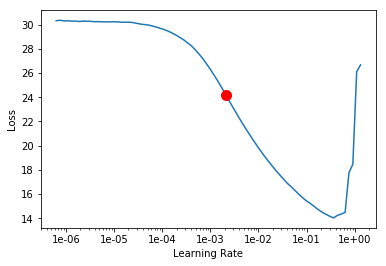

In [116]:
learn.lr_find(num_it=100)
learn.recorder.plot(suggestion=True)

In [117]:
learn.fit_one_cycle(4,  slice(2.09E-03))

In [118]:
learn.save(MODEL_PATH/'multilabel_lanchors_ssd_freeze-2_1')

In [66]:
learn.load(MODEL_PATH/'multilabel_lanchors_ssd_freeze-2_1')

Learner(data=ImageDataBunch;

Train: LabelList (4009 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Valid: LabelList (1002 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2):

In [127]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.17E-06
Min loss divided by 10: 7.94E-09


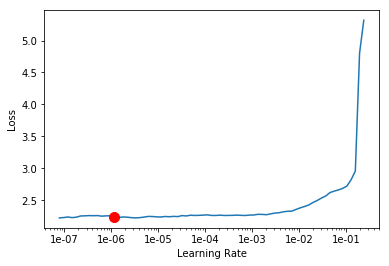

In [130]:
learn.lr_find(start_lr=1e-08, num_it=100)
learn.recorder.plot(suggestion=True)

Min numerical gradient: 1.17E-06
Min loss divided by 10: 7.94E-09


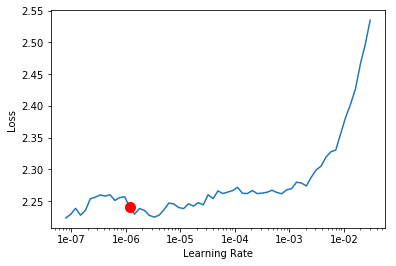

In [131]:
learn.recorder.plot(suggestion=True, skip_end=15)

In [132]:
learn.fit_one_cycle(5,  slice(1.17E-06, 3e-06))

In [133]:
learn.save(MODEL_PATH/'multilabel_lanchors_ssd_freeze-2_2')

In [71]:
learn.load(MODEL_PATH/'multilabel_lanchors_ssd_freeze-2_2')



Learner(data=ImageDataBunch;

Train: LabelList (4009 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Valid: LabelList (1002 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2):

In [149]:
learn.lr_find(start_lr=1e-08, num_it=150)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-08
Min loss divided by 10: 1.38E-08


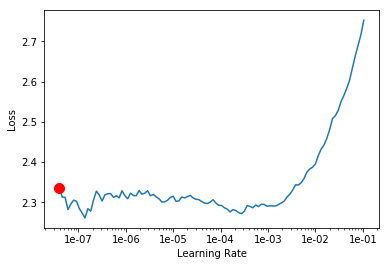

In [150]:
learn.recorder.plot(suggestion=True, skip_end=15)


In [151]:
learn.fit_one_cycle(4, slice(3.98E-08, 1.4e-07))

In [152]:
learn.save(MODEL_PATH/'multilabel_lanchors_ssd_freeze-2_3')

In [148]:
learn.load(MODEL_PATH/'multilabel_lanchors_ssd_freeze-2_3')

Learner(data=ImageDataBunch;

Train: LabelList (4009 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Valid: LabelList (1002 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2):

In [178]:
learn.lr_find(start_lr=1e-09, num_it=150)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.64E-09
Min loss divided by 10: 3.41E-09


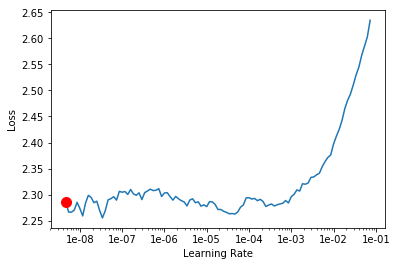

In [179]:
learn.recorder.plot(suggestion=True, skip_end=15)

In [180]:
learn.unfreeze()

In [181]:
learn.lr_find(start_lr=1e-09, num_it=150)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.17E-04
Min loss divided by 10: 4.64E-10


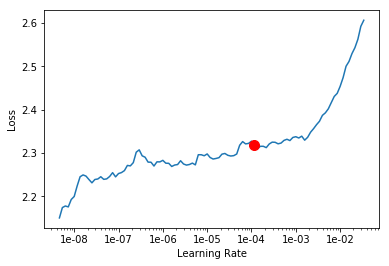

In [182]:
learn.recorder.plot(suggestion=True, skip_end=15)

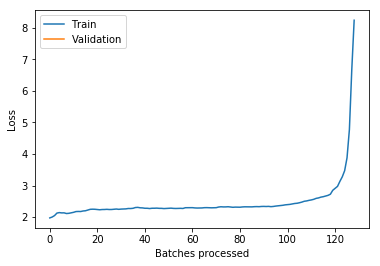

In [183]:
learn.recorder.plot_losses()

In [184]:
learn.freeze()

In [185]:
learn.lr_find(start_lr=1e-09, num_it=150)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.64E-09
Min loss divided by 10: 1.00E-09


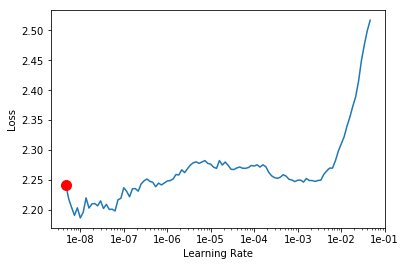

In [186]:
learn.recorder.plot(suggestion=True, skip_end=15)

In [187]:
learn.fit_one_cycle(4, slice(4.644E-09))

In [188]:
learn.save(MODEL_PATH/'multilabel_lanchors_ssd_freeze-2_4')

In [206]:
learn.freeze_to(-2)

In [207]:
learn.lr_find(start_lr=1e-10, num_it=150)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.98E-10
Min loss divided by 10: 4.11E-10


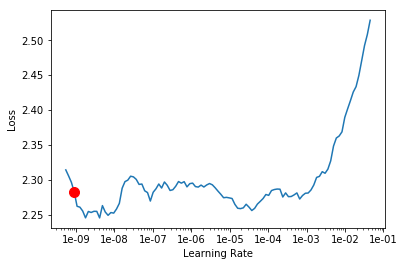

In [208]:
learn.recorder.plot(suggestion=True, skip_end=15)

In [209]:
learn.fit_one_cycle(2, slice(8.9e-10))

In [210]:
learn.save(MODEL_PATH/'multilabel_lanchors_ssd_freeze-2_5')

In [248]:
learn.freeze()

In [249]:
learn.lr_find(start_lr=1e-09, num_it=150)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-08
Min loss divided by 10: 8.58E-10


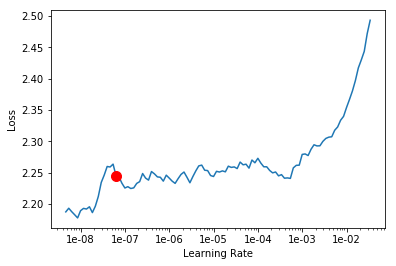

In [250]:
learn.recorder.plot(suggestion=True, skip_end=15)

In [ ]:
learn.fit_one_cycle(2, slice(6.31E-08))

### Continue here

In [ ]:
lr = 2.1e-05
lr/1000, lr/100, lr

### Visualise anchor boxes and ground truths by stepping through `ssd_1_loss`

1. For each batch we obtain the `xs` and `ys` which is image and the (coords and classes)
2. We extract the first image from the batch (sz=16) and return the coords, class indexs and the actual labels via this helper function
3. We then filter the non zero coordinates using the `get_nonzero` method which returns the coordinates but also scales it by dividing by 224. So the coordinates are now based on a 1x1 image.
4. We now try to obtain the overlaps using the `jaccard` with our anchor boxes as before which returns.
5. We now use the overlaps values to map this over our ground truth anchor boxes which returns the anchor box index with which the portion of the image overlaps and how much it overlaps by. 
6. We then filter out `postive_overlaps` by a threshold of `0.4`
7. We now mask all non positive overlaps by replacing the index of the ground truth class by 21 and leaving the values of the actual overlaps untouched. 

```python
    gt_classes = target_cls[gt_idx]
    positive_overlaps = gt_overlap > 0.4
    positive_overlaps_idx = torch.nonzero(positive_overlaps)[:, 0]    

    # if the overlaps are False replace that with 21 for all else retain the actual class label index
    gt_classes[~positive_overlaps] = len(data.classes)
    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_classes] #Ground truth labels 
```    
8. We then get the coordinates from our `t_coords` for those positive overlap indexes and pass this stuff to the loss function

In [45]:
iter_0 = iter(data.train_dl)

In [46]:
xs, ys = next(iter_0)


In [47]:
def get_overlaps(target_coords):
    anchor_centers = anchors[:, :2]
    anchor_hw = anchors[:, 2:]
    anchor_corners = hw2corners_(anchor_centers.cuda(), anchor_hw.cuda())  
    overlaps = jaccard(target_coords, anchor_corners.cuda())
    return overlaps

def get_ground_truth_labels(overlaps, target_coords, target_cls):
    try:
        gt_overlap, gt_idx = map_to_ground_truth(overlaps)
    except Exception as e:
        return 0., 0.
    
    gt_classes = target_cls[gt_idx]
    positive_overlaps = gt_overlap > 0.4
    positive_overlaps_idx = torch.nonzero(positive_overlaps)[:, 0]    

    # if the overlaps are False replace that with 21 for all else retain the actual class label index
    gt_classes[~positive_overlaps] = len(data.classes)
    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_classes] #Ground truth labels   
    gt_bbox = t_coords[gt_idx]
    return gt_bbox, gt_label

def show_expectation(idx, x_s, y_s):
    _, _, ll = get_(idx, x_s, y_s)
    img = vision.Image(x_s[idx])
    print(ll)
    img.show()
    

def get_(idx, x_s, y_s):
    target_coords, target_labels = ys
    t_coords, t_labels = target_coords[idx], target_labels[idx]
    ll = [data.classes[l] for l in t_labels]
    return t_coords, t_labels, ll
    

In [50]:
idx = 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'car', 'car', 'person', 'person']


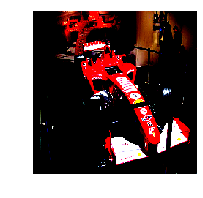

In [51]:
show_expectation(idx, xs, ys)

In [52]:
t_c, t_cls, ll = get_(idx, xs, ys); t_c, t_cls, ll

(tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.6373, -0.5080,  0.9520,  0.9160],
         [-1.0000, -0.8240, -0.2587,  0.1920],
         [-0.8507,  0.5160, -0.2320,  0.7040],
         [-0.8240,  0.6560, -0.2587,  0.8200]], device='cuda:0'),
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  7, 15, 15], device='cuda:0'),
 ['background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'background',
  'car',
  'car',
  'person',
  'person'])

In [188]:
data.classes[20]

'tvmonitor'

In [53]:
t_c, t_cls = get_nonzero(t_c, t_cls)

In [54]:
overlaps = get_overlaps(t_c); overlaps
gt_overlaps, gt_idx = map_to_ground_truth(overlaps)

In [55]:
gt_classes = t_cls[gt_idx];gt_classes, gt_classes.shape

(tensor([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7, 15, 15, 15, 15, 15, 15, 15, 15, 15,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7, 15, 15, 15, 15, 15, 15, 15, 15, 15,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7, 15, 15, 15,  7, 15, 15,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7], device='cuda:0'),
 torch.Size([189]))

In [56]:
pos_overlaps = gt_overlaps > 0.4; pos_overlaps, pos_overlaps.shape

(tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [57]:
pos_overlap_idx = torch.nonzero(pos_overlaps)
pos_overlap_idx = pos_overlap_idx[:, 0]
pos_overlap_idx, pos_overlap_idx.shape


(tensor([ 15,  28, 144, 147, 148, 149, 150, 151, 152, 154, 177, 180, 181, 183,
         184, 185, 187, 188], device='cuda:0'), torch.Size([18]))

In [58]:
gt_classes[~pos_overlaps] = len(data.classes); gt_classes, gt_classes.shape

(tensor([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,  7, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
          7, 21, 21,  7,  7,  7,  7,  7,  7, 21, 15, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,  7, 21, 21,
          7,  7, 21,  7,  7,  7, 21,  7,  7], device='cuda:0'),
 torch.Size([189]))

In [59]:
gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_classes.detach()]; gt_label, len(gt_label)

([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  15,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  0,
  7,
  7,
  7,
  7,
  7,
  7,
  0,
  15,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  0,
  7,
  7,
  0,
  7,
  7,
  7,
  0,
  7,
  7],
 189)

In [60]:
gt_bbox = t_c[gt_idx]; gt_bbox.shape

torch.Size([189, 4])

In [199]:
gt_bbox * 224.

tensor([[-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.9673,  157.9648,  158.5662],
        [-174.8634,   18.967

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.2032, -0.0416,  0.7519,  0.2512],
         [-0.2838, -0.6628,  0.6993, -0.3646],
         [-0.2590,  0.6451,  0.8571,  1.0000],
         [ 0.2322,  0.2264,  0.4416,  0.3265]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 4

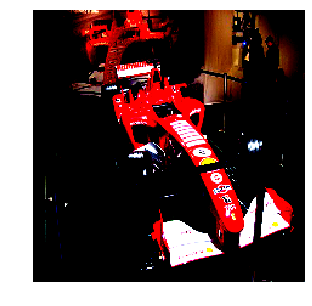

In [61]:
print(ys[0])
print('---------------------')
print(t_c.cpu() * 224.)

img = vision.Image(xs[idx])
s_bb = ImageBBox.create(*img.size, bboxes=(t_c.cpu()) * 224., labels=[15] * 3, classes=data.classes)
print(s_bb.flow)
img.show(y=s_bb, figsize=(5, 5))


tensor([-174.8634,   18.9673,  157.9648,  158.5662], device='cuda:0')
tensor([-105.9400, -194.5510,  199.5887,   30.4017], device='cuda:0')
tensor([-214.4163,   -8.3752,   -0.8356,  205.1883], device='cuda:0')
tensor([-214.4163,   -8.3752,   -0.8356,  205.1883], device='cuda:0')
tensor([-214.4163,   -8.3752,   -0.8356,  205.1883], device='cuda:0')
tensor([-214.4163,   -8.3752,   -0.8356,  205.1883], device='cuda:0')


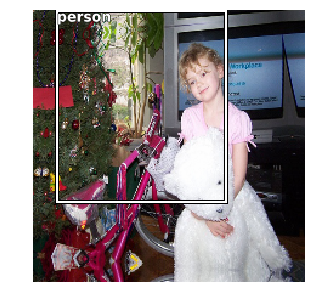

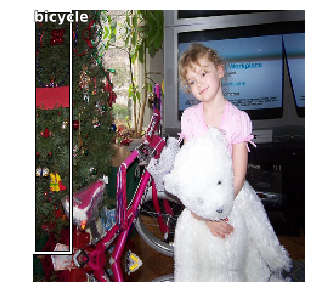

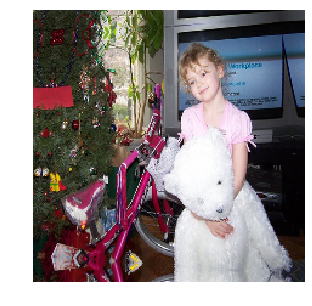

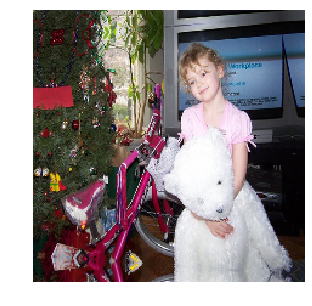

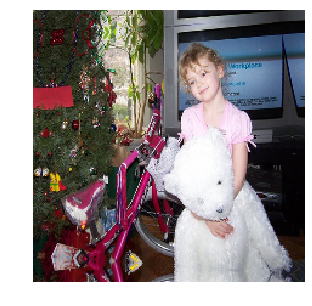

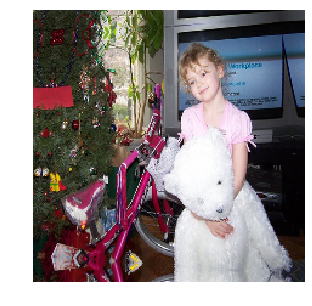

In [205]:

for bb, l in zip(gt_bbox, gt_label):    
    if l !=0:             
        bb = ((bb) * 224.)
        print(bb)
        bbox = ImageBBox.create(*img.size, bb.unsqueeze(0).cpu(), labels=[l], classes=data.classes)
        img.show(y=bbox, figsize=(5,5))

### Test predictions.

In [317]:
iter_batch = iter(learn.data.valid_dl)

In [318]:
batch = next(iter_batch)
xb, yb = batch
learn.model.eval()
preds = learn.pred_batch(xb)

### Non Max Suppression (NMS)


In [388]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (2501 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Valid: LabelList (2510 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2):

In [216]:
iter_ = iter(learn.data.valid_dl)

In [225]:
xb,yb = next(iter_)

# Predict results based on the input image batch
learn.model.eval()
preds = learn.pred_batch(xb)
b_clas, b_bb = preds

In [226]:
b_clas.shape, b_bb.shape

(torch.Size([16, 189, 21]), torch.Size([16, 189, 4]))

In [227]:
yb_cords, yb_classes = yb[0], yb[1]
yb_cords.shape, yb_classes.shape

(torch.Size([16, 17, 4]), torch.Size([16, 17]))

In [246]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count



def process_nmf(idx, debug=True):
    '''
    Connects to the nmf algorith to filter out dupplicate bounding boxes
    ''' 
    # Minimun threshold for eliminating background noise
    min_thresh = 0.2   #0.25
    
    # Maximun threshold for eliminating duplicate boxes
    max_thresh = 0.22 
    
     # Extract predicted classes
    clas_pr, clas_ids = b_clas[idx].max(dim=1)

    
    # Mask Index of classes whose contents are over the noise level: 0 if the index contains no boxes, 1 if it does
    clas_pr = clas_pr.sigmoid()    
    
    # Calculate confidence score for Class Activations
    conf_scores = b_clas[idx].sigmoid().t().data  
    
    
    # Converts activation vectors to boxes. Shape: 189 x 4
    p_final_bbox = actn_to_bb(b_bb[idx].cpu(), anchors, grid_sizes=grid_sizes) 
    
    # lists for accumulating selected boxes and classes
    tot_bx, tot_cls = [], []
    
    scrd_cls_lst = data.classes.copy()
  
    # Loop across all classes
    for cl in range(0, len(conf_scores)):
        
        # Filter out Backgrounds and empty box arrays        
        c_mask = conf_scores[cl] > min_thresh         
        if c_mask.sum() == 0 or cl == 0: continue
        
        
        # scores for the selected class 
        scores = conf_scores[cl][c_mask] # Tensor 
           
        # These are active boxes. Ready to be processed by nmf
        boxes = p_final_bbox.cpu().index_select(dim=0,index=c_mask.nonzero().squeeze())
        
        # Run NMF
        ids, count = nms(boxes.data, scores, overlap=0.5, top_k=100)
        ids = ids[:count]
        
    
        
        # Filter all boxes & classes over the threshold and accumulate them in lists
        for i, (sc, bx) in enumerate(zip(scores, boxes.data[ids] )): 
                 
            tot_bx.append(bx)
            tot_cls.append(cl)
            # Create a scored label
            f = f'{i}: '           
            l = f'{data.classes[cl]} '
            s = '{0:.2f}'.format(sc) 
            sl = f+l+s
            # print('scored label: {} '.format(sl))
            scrd_cls_lst[cl] = sl

                
    if not tot_cls:
        print('Inferred Class list is empty. Image may be too faint.')
        return None, None, None  
    
    return torch.cat(tot_bx).view(-1, 4), torch.tensor((np.array(tot_cls))), scrd_cls_lst


# Filter Single Image
def show_filtered_img_by_ndx(idx):
    
    
    # Prepare ground-truth image for display
#     img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))        
    img = vision.Image(denormalize(xb[idx], *tensor(imagenet_stats)))
    img_box = ImageBBox.create(224,224,yb_cords[idx].cpu(),labels=yb_classes[idx],classes=data.classes,scale=False)
    
    # Unpad Y (ground-truth boxes and classes )
    t_bbox,t_clas = get_nonzero(yb_cords[idx], yb_classes[idx])
     
    # Process NMF 
    tot_bx, tot_cls, scrd_cls_lst = process_nmf(idx)  # Filter dupplicate boxes
    if tot_bx is None: return         
   
    ll = [data.classes[o] for o in tot_cls.cpu()]
    print(f'{idx} - {ll}')
    # Compose the image, bouding boxes, ans classes for display
    p_img_box = ImageBBox.create(224,224,tot_bx.cpu(),tot_cls.cpu(),classes=scrd_cls_lst,scale=False)
  
    # Display resulting image, selected bounding boxes, and class labels
    fig,axes = plt.subplots(1,2,figsize=(10,6))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction')
   

0 - ['aeroplane', 'car']
1 - ['aeroplane', 'bird', 'car', 'car', 'horse', 'person']
2 - ['cat', 'dog', 'person', 'person', 'person', 'person']
3 - ['dog', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']
4 - ['chair', 'chair', 'chair', 'chair', 'chair', 'diningtable', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'sofa', 'sofa']
5 - ['car', 'person', 'person']
6 - ['chair', 'chair', 'diningtable', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'sofa']
7 - ['car', 'person', 'person']
8 - ['chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'diningtable', 'person', 'person', 'person', 'person', 'person', 'person', 'sofa', 'sofa', 'sofa']
9 - ['aeroplane', 'bird', 'car', 'car', 'horse', 'person', 'person']
10 - ['person', 'person', 'person']
11 - ['aeroplane', 'car', 'cat', 'dog', 'person', 'person']
12 - ['cat', 'dog', 'person', 'person', 'person']
13 - ['car', 'cat

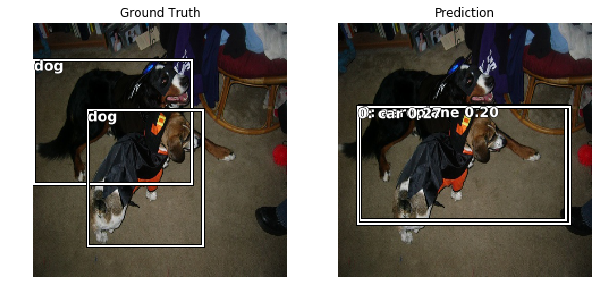

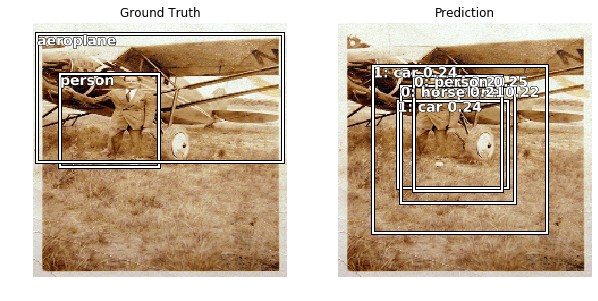

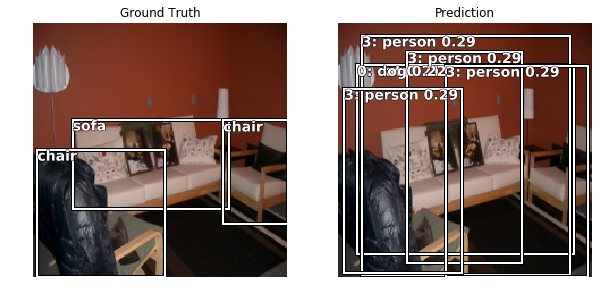

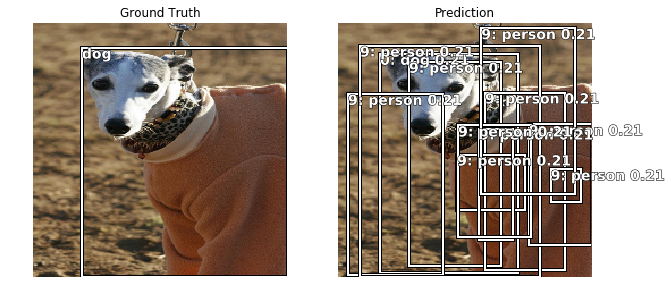

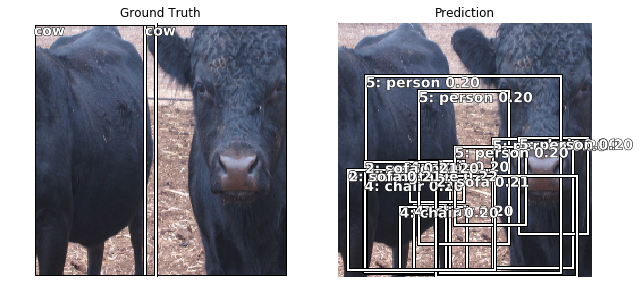

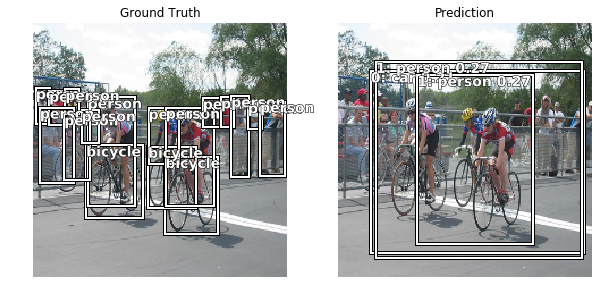

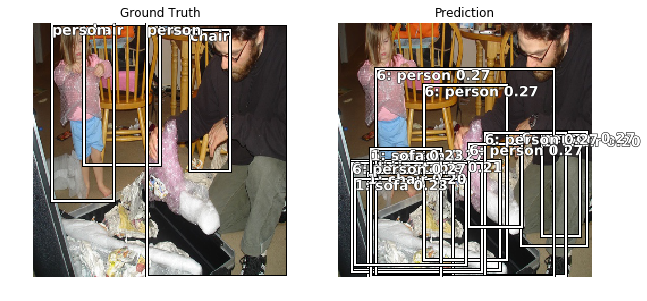

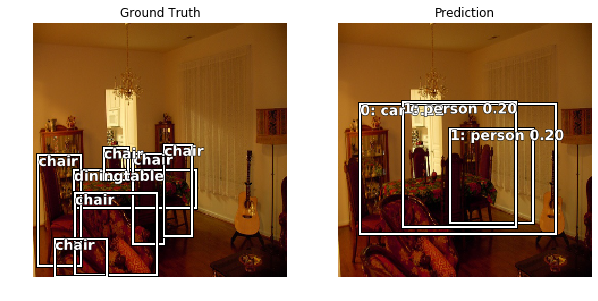

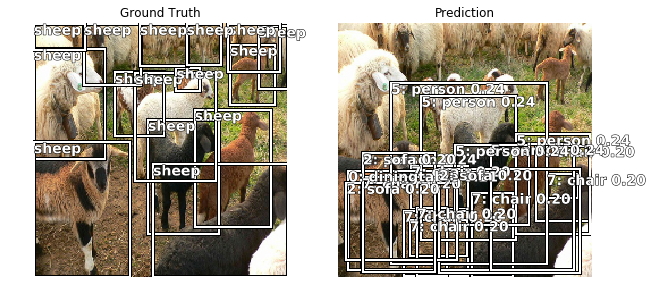

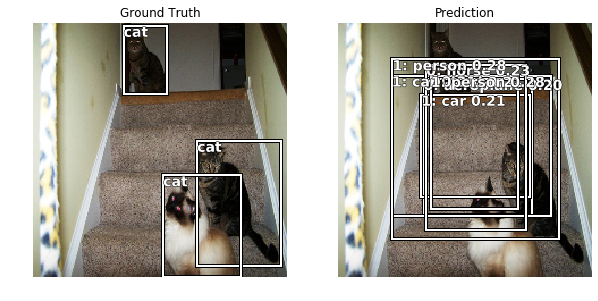

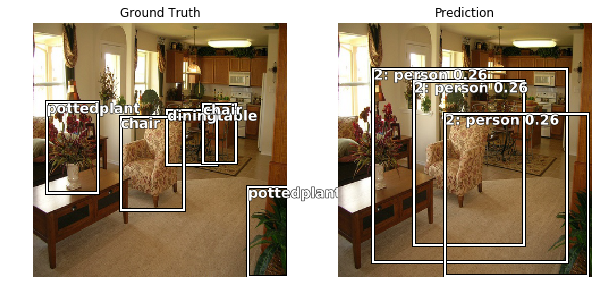

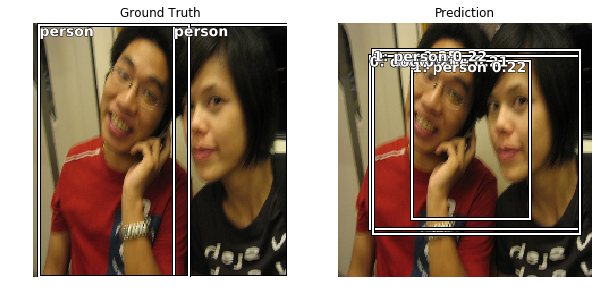

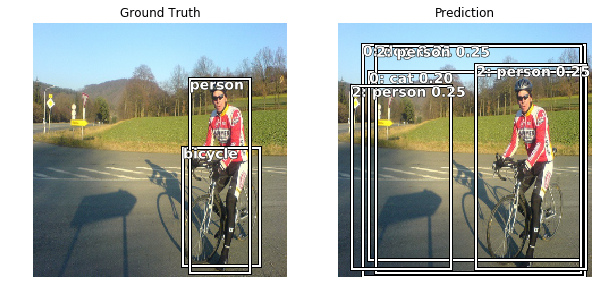

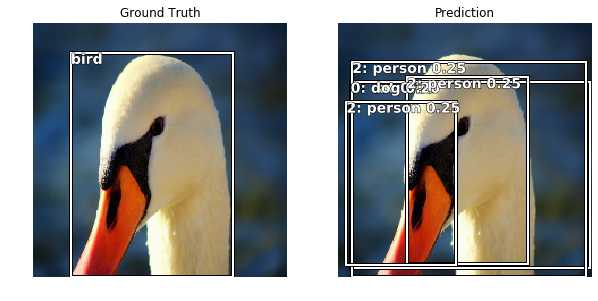

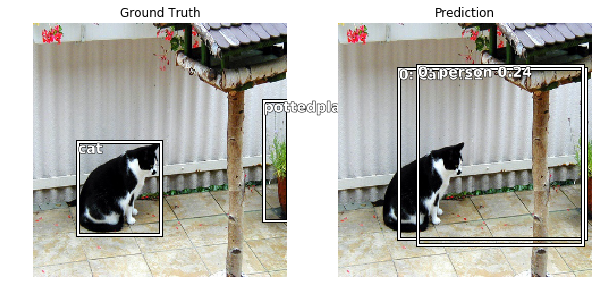

In [247]:
for i in range(15):
    show_filtered_img_by_ndx(i)

    

In [239]:
data.classes

['background',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [192]:
iter_batch = iter(learn.data.valid_dl)



In [203]:
batch = next(iter_batch)
xb, yb = batch
preds = learn.model(xb)

In [204]:
def show_pred_next_to_ground_truth(idx, xb, yb, preds, thresh=None):    
    y_coords, y_cls = yb    
    
    target_coords, target_cls = get_nonzero(y_coords[idx], y_cls[idx])    

    # because get_nonzero divides by 224    
    pred_cls, pred_coords = preds
    
    pred_cls_mvals, pred_cls_midx = pred_cls[idx][:, 1:].max(dim=1)
    
    
  
    print(pred_cls_midx)
    
    # Compute threshold
    threshold = [thresh] if thresh else [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.35, 0.32, 0.2]
    
    for _, i in enumerate(threshold):
        idx_cls = pred_cls_mvals.sigmoid() > i        
        if idx_cls.sum() == 0:    
            continue
        else:
            print(f'Threshold at :{i}')
            break
    
#     print(pred_cls_midx)
#     print(idx_cls)
    
    pred_final_cls = (pred_cls_midx + 1) * (idx_cls).long()        
    img = Image(denormalize(xb[idx].cpu(), *tensor(imagenet_stats)))
#     print(f'{idx} - pred_cls: {pred_final_cls}')
#     print(f'{list(zip((pred_cls_midx + 1).tolist(), pred_cls_mvals.sigmoid().tolist()))}')
    
    # Ground Truth
    img_bbox =  ImageBBox.create(*img.size, target_coords.cpu(), 
                                 labels=target_cls, 
                                 classes=data.classes, scale=False)
    
    
    
    # Prediction    
    p_final_actn = actn_to_bb(pred_coords[idx].cuda(), anchors.cuda(), grid_sizes.cuda())
    
    
    p_final_bbox = p_final_actn.cuda().index_select(dim=0, 
                                                    index=idx_cls.nonzero().squeeze().cuda())
    
    
    
#     p_final_bbox = (p_final_bbox)
    
    
    p_final_cls = pred_final_cls.index_select(dim=0,
                                              index=idx_cls.nonzero().squeeze()) 
#     print(f'p_final_cls: {p_final_cls}')
    
    
    
    pred_img_bbox = ImageBBox.create(*img.size, p_final_bbox.cpu(), 
                                     labels=p_final_cls, 
                                     classes=data.classes, scale=False)
    
    
    
    
    # display
    fix, axes = plt.subplots(1, 2, figsize=(10, 6))
    img.show(ax=axes[0], y=img_bbox, title='Ground Truth')
    img.show(ax=axes[1], y=pred_img_bbox, title='Prediction')

    




tensor([14,  4,  4, 14, 14,  6,  6, 14,  6,  6,  6,  6,  6,  6,  4, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14,  6, 14, 14,  6, 14, 14, 14, 14, 14,
        14, 14, 14,  6, 14,  6,  6,  6,  9,  9, 14,  6, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  4, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14,  8, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
         6, 14, 14,  8,  8, 14, 14, 14,  8, 14, 14, 11,  8,  8,  8,  8,  8,  8,
         8,  8, 14, 14, 14, 14, 14, 14, 14,  8, 14, 14,  8,  8, 14,  8,  8, 14,
        14, 14, 14, 14, 14,  6, 14, 14, 14, 14, 15,  6, 14,  8,  8, 14, 14, 14,
        14, 14, 14, 14, 14, 13, 14, 14,  1, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 11, 14, 14], device='cuda:0')
Threshold at :0.2
tensor([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 14,  6,  6,
        14,  6,  6,  6,  6,  6,  6,  6, 

tensor([ 6,  6,  6,  6, 14,  6,  4,  6,  6,  4,  4, 14,  6,  6,  6, 14,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 14, 14, 14, 14, 14,  6, 14,  6,
        15, 15, 15,  6,  6,  6,  6,  6,  9,  6, 14,  6, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14,  8,  8, 14, 14, 14,  8, 14, 14,  8,
         8,  6, 14, 14,  8, 14, 14, 14,  8,  8,  8,  8,  8,  8,  8, 14, 14,  8,
         6, 14, 14,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8, 14,  6,  8,  8,  8,  6,  6,  8,  8,  1,  8,  8,  8,  6,  6,  8,  8,
        14, 14,  6, 14, 15,  6,  6, 19,  6,  6, 15,  6,  6, 14,  6,  6, 14,  6,
         8,  8, 15, 14, 14, 17, 14, 14, 17, 14,  8,  1, 17, 14,  6, 17, 14, 17,
        14, 14,  6, 14, 14,  6, 14, 14, 14], device='cuda:0')
Threshold at :0.2
tensor([ 6, 15, 14, 14, 14,  6,  6,  6,  6,  6,  6, 14,  6,  6,  6, 14, 14, 14,
        14, 14,  6, 14, 14, 14, 14, 14, 

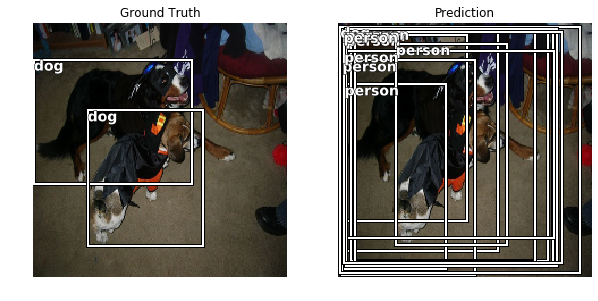

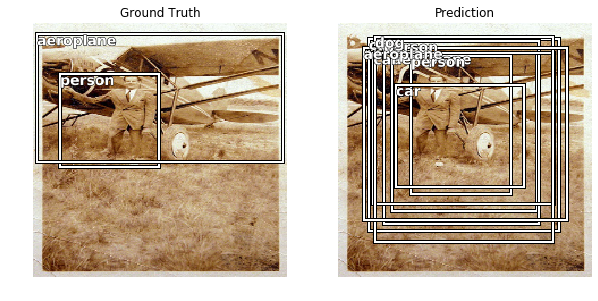

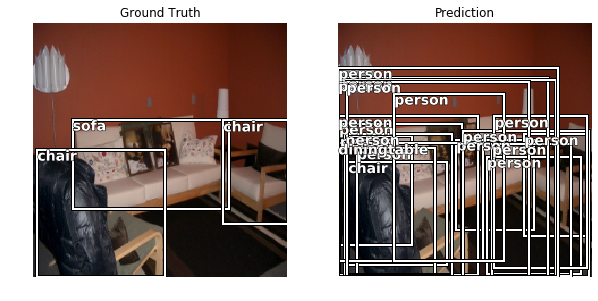

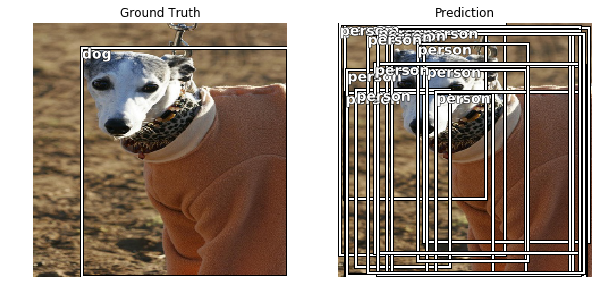

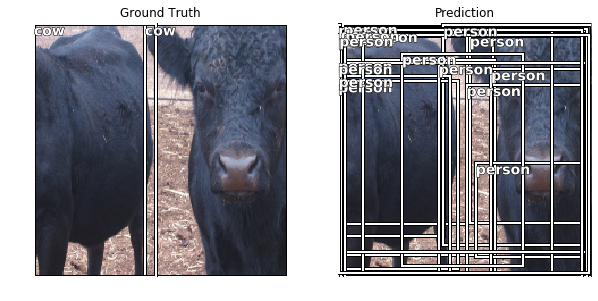

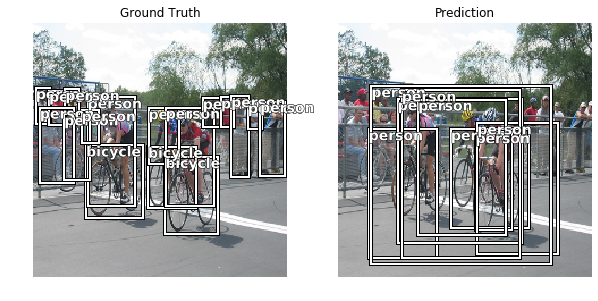

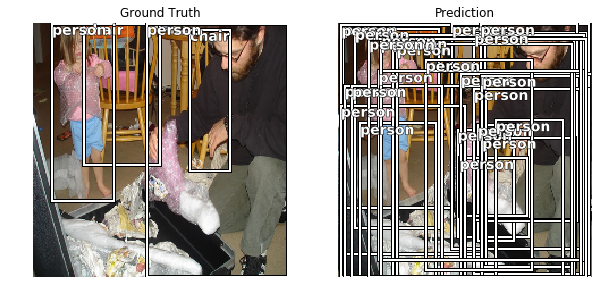

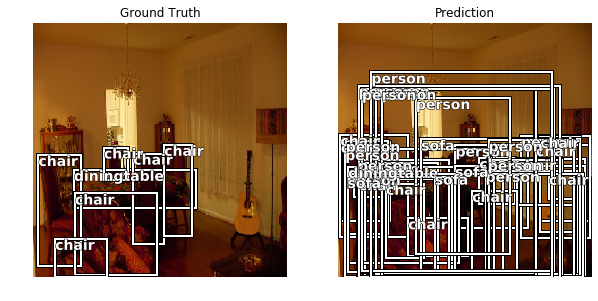

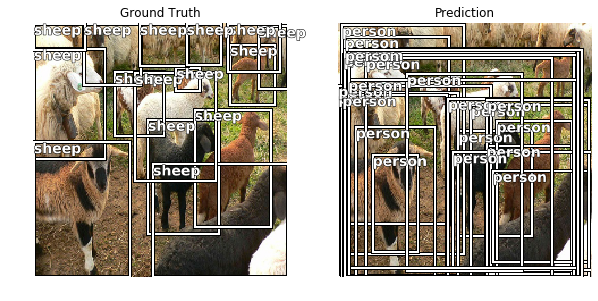

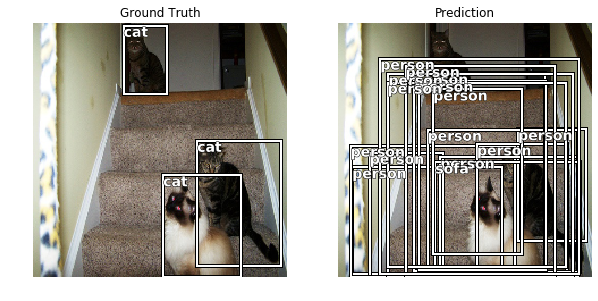

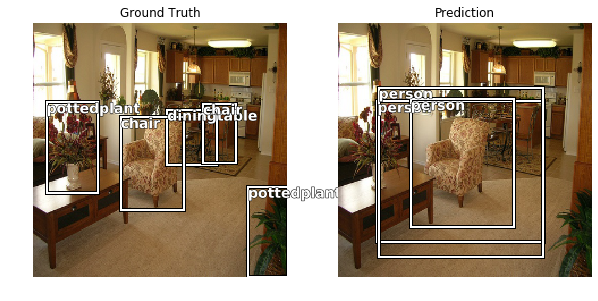

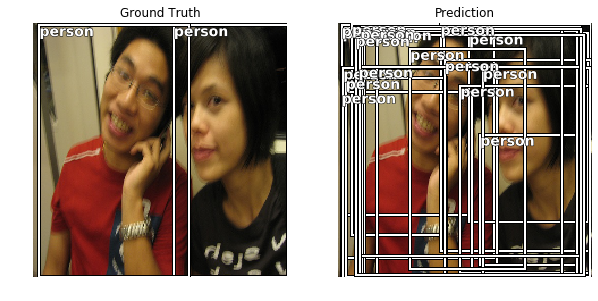

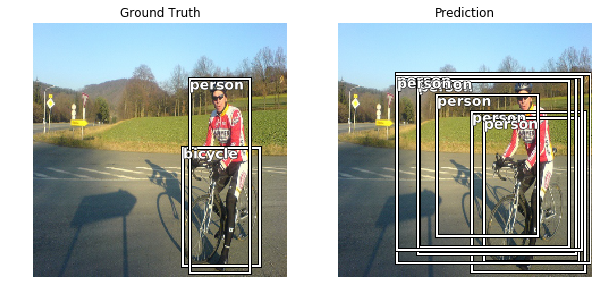

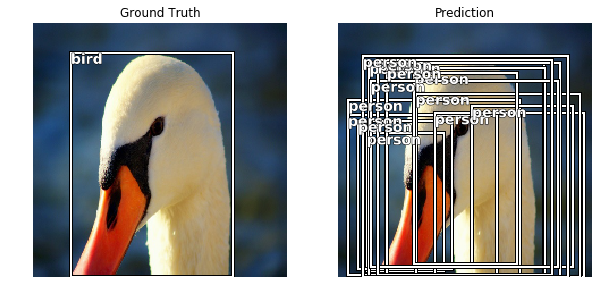

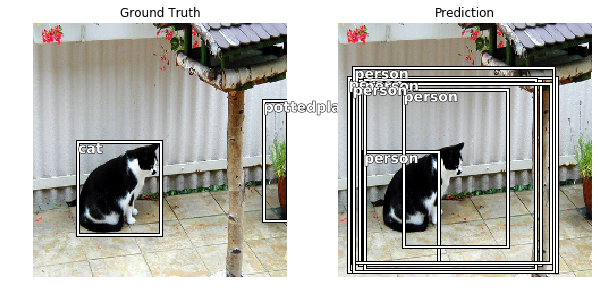

In [205]:
for i in range(15):
    show_pred_next_to_ground_truth(i, xb, yb, preds=preds, thresh=0.2)


In [82]:
for i, c in enumerate(data.classes):
    print(i, c)

0 background
1 aeroplane
2 bicycle
3 bird
4 boat
5 bottle
6 bus
7 car
8 cat
9 chair
10 cow
11 diningtable
12 dog
13 horse
14 motorbike
15 person
16 pottedplant
17 sheep
18 sofa
19 train
20 tvmonitor


### Show a single image

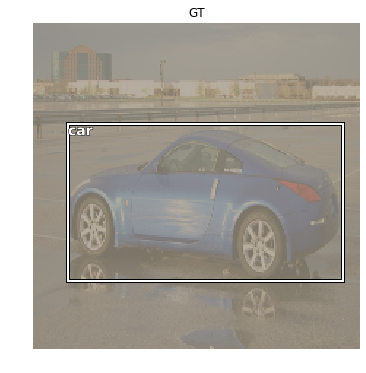

In [60]:
idx=0
x, y = next(iter(data.valid_dl))
img = Image(denormalize(x[idx], *tensor(imagenet_stats)))
bbox = ImageBBox.create(*img.size, y[0][idx].cpu(), labels=y[1][idx], classes=data.classes, scale=False)
fig, axes = plt.subplots(1, 1, figsize=(10,6))
img.show(ax=axes, y=bbox, title='GT')

### Defining the Anchors for a grid

### Creating the anchor box grid

#### `np.linspace`    

    Return evenly spaced numbers over a specified interval.

    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].

    The endpoint of the interval can optionally be excluded.
    
```python
def np.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)  
```

#### `np.repeat`

    Repeat elements of an array.

```python
def repeat(a, repeats, axis=None):
```    

#### `np.tile`

    Construct an array by repeating A the number of times given by reps.
    
```python    
def tile(A, reps):
```

In [6]:
from torch.autograd import Variable as V

In [14]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2) # 0.125
anc_offset

0.125

#### np.linspace

Generates 4 evenly spaced set of points between `0.125` and `1 - 0.125`. 

In [32]:
np.linspace(0., 100., num=5)

array([  0.,  25.,  50.,  75., 100.])

In [18]:
four_point_grid = np.linspace(anc_offset, 1-anc_offset, anc_grid); four_point_grid

array([0.125, 0.375, 0.625, 0.875])

#### np.repeat

Repeats the `four_point_grid` created earlier 4 times

In [49]:
np.repeat([1, 2], 3)

array([1, 1, 1, 2, 2, 2])

#### Creating the x-axis coordinates

In [20]:
anc_x = np.repeat(four_point_grid, anc_grid); anc_x

array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625, 0.625, 0.625, 0.625, 0.875, 0.875, 0.875, 0.875])

In [21]:
np.tile??

In [33]:
np.tile([1, 2, 3], 5)

array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3])

In [83]:
anc_y = np.tile(four_point_grid, anc_grid); anc_y

array([0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875])

In [46]:
arr_sequence = [[1, 2, 3], ['a', 'b', 'c'], [0.1, 0.2, 0.3]]
print(np.stack(arr_sequence, axis=1))
print("\n")
print(np.stack(arr_sequence, axis=0))

[['1' 'a' '0.1']
 ['2' 'b' '0.2']
 ['3' 'c' '0.3']]


[['1' '2' '3']
 ['a' 'b' 'c']
 ['0.1' '0.2' '0.3']]


In [51]:
anc_x, anc_y

(array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625, 0.625, 0.625, 0.625, 0.875, 0.875, 0.875, 0.875]),
 array([0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875]))

In [53]:
anc_centers = np.stack([anc_x, anc_y], axis=1); anc_centers

array([[0.125, 0.125],
       [0.125, 0.375],
       [0.125, 0.625],
       [0.125, 0.875],
       [0.375, 0.125],
       [0.375, 0.375],
       [0.375, 0.625],
       [0.375, 0.875],
       [0.625, 0.125],
       [0.625, 0.375],
       [0.625, 0.625],
       [0.625, 0.875],
       [0.875, 0.125],
       [0.875, 0.375],
       [0.875, 0.625],
       [0.875, 0.875]])

In [77]:
anc_ctrs = np.tile(anc_centers, (k, 1))

#### Anchor Sizes width x height

In [82]:
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anc_sizes

array([[0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25]])

#### Creating anchors

In [100]:
anchors = np.concatenate([anc_ctrs, anc_sizes], axis=1); anchors
anchors = torch.Tensor(anchors)
anchors = V(anchors, requires_grad=False).float()
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]])

In [97]:
grid_sizes = torch.Tensor(np.array([1/anc_grid])); grid_sizes
grid_sizes = V(grid_sizes, requires_grad=False).unsqueeze(1); grid_sizes

tensor([[0.2500]])

### Anchors in summary

In [28]:
from torch.autograd import Variable as V

anc_grid = 4
k = 1


anc_offset = 1/(anc_grid*2) # 0.125
four_point_grid = np.linspace(anc_offset, 1-anc_offset, anc_grid)
anc_x = np.repeat(four_point_grid, anc_grid)
anc_y = np.tile(four_point_grid, anc_grid); anc_y

# anchor centers
anc_centers = np.stack([anc_x, anc_y], axis=1);
anc_ctrs = np.tile(anc_centers, (k, 1))

# anchor sizes
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])

#anchor coords and height and width
anchors = np.concatenate([anc_ctrs, anc_sizes], axis=1); anchors
anchors = torch.Tensor(anchors)
anchors = V(anchors, requires_grad=False).float()

# grids
grid_sizes = torch.Tensor(np.array([1/anc_grid])); grid_sizes
grid_sizes = V(grid_sizes, requires_grad=False).unsqueeze(1)

In [30]:
grid_sizes


tensor([[0.2500]])

### Quick Testing  - Display the training or validation datasets with their bounding boxes by regenerating the info

This includes three steps

1. Fetch the image from a batch
2. Reconstruct the image `x` using the reconstruct method
3. Reconstruct the bounding boxes `y`

4. Manually reconstruct the `y[idx]` by running it through a `sigmoid` to convert the negative values to positive and multiply it with a factor (2 or 3).
5. Resize the `y[idx]` by multiplying it with the imagenet sizes 224
6. Append the bounding box corner values which is generated by calling the `anchor_coords = hw2corners(anchors[:, :2], anchors[:, 2:])` which turns the anchor height and width into corner coordinates

```python
idx=6
y[0][idx], y[1][idx]

# learn.data.denorm(x)
xs = data.train_ds.x.reconstruct(x[idx])
bbx = data.train_ds.y.reconstruct(grab_idx(y, idx), xs)
xs.show(y=bbx)


bbox, la = y
i = la.nonzero().min()
# print(bbx.flow, (bbox[idx][i:]))
print(la[idx])
img_bbx = torch.sigmoid(bbox[idx][i:] * 3)

w =  ['bird'] + [''] * 16

anchor_coords = hw2corners(anchors[:, :2], anchors[:, 2:])
c_bbx = torch.cat((img_bbx, anchor_coords))
ibbx = ImageBBox.create(*xs.size, c_bbx*224, classes=[w])
ibbx2 = ImageBBox.create(*xs.size, img_bbx*224, classes=[w])
xs.show(y=ibbx)
xs.show(y=ibbx2)
```

In [40]:
def qt_display_img_with_bbox(ds_type:DatasetType=data.train_ds):
    one_batch = data.one_batch(ds_type=ds_type)
    x, y = one_batch
    for idx in range(2):           
        y[0][idx], y[1][idx]

        # Reconstruct the original image using fastai helpers
        xs = data.train_ds.x.reconstruct(x[idx])
        bbx = data.train_ds.y.reconstruct(grab_idx(y, idx), xs)
        

        # Do it manually
        bbox, la = y
        i = la.nonzero().min()                
        img_bbx = (bbox[idx][i:] + 1.)/2. # torch.sigmoid(bbox[idx][i:] * 3)

        w =  ['bird'] + [''] * 16

        # Append the anchor bboxs to the display
        anchor_coords = hw2corners(anchors[:, :2], anchors[:, 2:])
        c_bbx = torch.cat((img_bbx, anchor_coords))
        
        ibbx = ImageBBox.create(*xs.size, c_bbx*224, classes=[w])
        ibbx2 = ImageBBox.create(*xs.size, img_bbx*224, classes=[w])
        xs.show(y=bbx)
        xs.show(y=ibbx, figsize=(10, 10))
        xs.show(y=ibbx2)

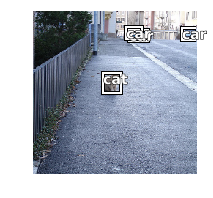

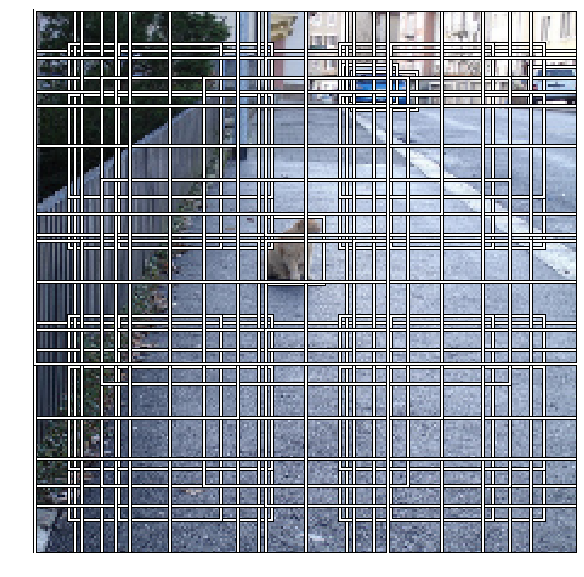

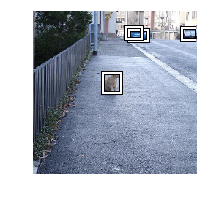

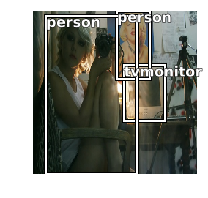

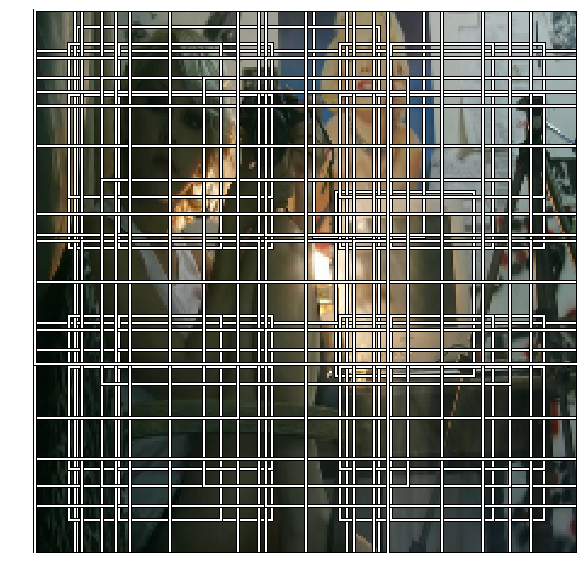

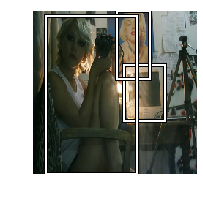

In [41]:
qt_display_img_with_bbox()